In [1]:
import numpy as np
from numba import njit
import time

# ----- Experiment parameters -----
n = 1000      # number of vertices in the graph
p = 0.8     # edge probability in G(n, p)
M = 5000      # number of random graphs in the simulation later

print("Parameters for G(n, p) experiment:")
print(f"  n (number of vertices): {n}")
print(f"  p (edge probability):   {p}")
print(f"  M (number of samples):  {M}")

Parameters for G(n, p) experiment:
  n (number of vertices): 1000
  p (edge probability):   0.8
  M (number of samples):  5000


In [2]:
import matplotlib.pyplot as plt

# For Jupyter: show plots inside the notebook
%matplotlib inline

In [3]:
def generate_gnp(n, p, rng=None):
    """
    Generate an undirected G(n, p) random graph as an adjacency matrix.

    Parameters
    ----------
    n : int
        Number of vertices.
    p : float
        Edge probability (0 <= p <= 1).
    rng : np.random.Generator or None
        Random number generator. If None, a new default generator is used.

    Returns
    -------
    A : np.ndarray of shape (n, n), dtype=np.int8
        Symmetric adjacency matrix with zeros on the diagonal.
    """
    if rng is None:
        rng = np.random.default_rng()

    # Start with all zeros
    A = np.zeros((n, n), dtype=np.int8)

    # Indices of the upper triangle (i < j)
    iu, ju = np.triu_indices(n, k=1)

    # For each potential edge, draw a Bernoulli(p)
    edges = rng.random(iu.size) < p   # Boolean array

    # Fill the upper triangle
    A[iu, ju] = edges.astype(np.int8)

    # Mirror to lower triangle to make the graph undirected
    A[ju, iu] = A[iu, ju]

    return A

In [4]:
A_test = generate_gnp(n, p)
print("Shape:", A_test.shape)
print("Symmetric:", np.all(A_test == A_test.T))
print("Diagonal sum (should be 0):", np.trace(A_test))
print("Number of edges:", A_test.sum() // 2)

Shape: (1000, 1000)
Symmetric: True
Diagonal sum (should be 0): 0
Number of edges: 399499


In [5]:
def count_triangles_py(A):
    """
    Count triangles in an undirected graph given by its adjacency matrix A.

    Parameters
    ----------
    A : np.ndarray of shape (n, n)
        Symmetric adjacency matrix with zeros on the diagonal.

    Returns
    -------
    count : int
        Number of triangles in the graph.
    """
    n = A.shape[0]
    count = 0

    # Loop over all triples i < j < k
    for i in range(n):
        for j in range(i + 1, n):
            if A[i, j] == 0:
                # If there's no edge (i, j), they can't form a triangle with any k
                continue
            for k in range(j + 1, n):
                # Check if edges (i, k) and (j, k) are present
                if A[i, k] == 1 and A[j, k] == 1:
                    count += 1

    return count

In [6]:
A_small = np.array([
    [0, 1, 1, 0],
    [1, 0, 1, 0],
    [1, 1, 0, 0],
    [0, 0, 0, 0],
], dtype=np.int8)

print("A_small:")
print(A_small)
print("Triangle count (expected 1):", count_triangles_py(A_small))

A_small:
[[0 1 1 0]
 [1 0 1 0]
 [1 1 0 0]
 [0 0 0 0]]
Triangle count (expected 1): 1


In [7]:
@njit
def count_triangles_numba(A):
    n = A.shape[0]
    count = 0

    for i in range(n):
        for j in range(i + 1, n):
            if A[i, j] == 0:
                continue
            for k in range(j + 1, n):
                if A[i, k] == 1 and A[j, k] == 1:
                    count += 1

    return count

In [8]:
# Small warm-up call (compiles Numba function)
_ = count_triangles_numba(A_small)

# Check on the known test example
print("Numba triangle count (expected 1):", count_triangles_numba(A_small))

Numba triangle count (expected 1): 1


In [9]:
# Generate a single random graph for timing
A_big = generate_gnp(n, p)
print("Graph for timing generated with shape:", A_big.shape)

# --- Time pure Python version ---
t0 = time.perf_counter()
tri_py = count_triangles_py(A_big)
t1 = time.perf_counter()
time_py = t1 - t0

# --- Time Numba version ---
# First call is already done earlier on A_small, so it's compiled.
t0 = time.perf_counter()
tri_numba = count_triangles_numba(A_big)
t1 = time.perf_counter()
time_numba = t1 - t0

print(f"Triangle count (Python): {tri_py}")
print(f"Triangle count (Numba):  {tri_numba}")
print(f"Times: Python = {time_py:.6f} s, Numba = {time_numba:.6f} s")

if time_numba > 0:
    print(f"Speedup (Python / Numba): {time_py / time_numba:.2f}x")

Graph for timing generated with shape: (1000, 1000)
Triangle count (Python): 84591583
Triangle count (Numba):  84591583
Times: Python = 19.066721 s, Numba = 0.136875 s
Speedup (Python / Numba): 139.30x


In [10]:
def theoretical_mean(n, p):
    # C(n, 3) * p^3
    return (n * (n - 1) * (n - 2) / 6.0) * (p ** 3)


def theoretical_var(n, p):
    # C(n, 3) * (p^3 - p^6) + 3 * C(n, 4) * (p^5 - p^6)
    c3 = n * (n - 1) * (n - 2) / 6.0
    c4 = n * (n - 1) * (n - 2) * (n - 3) / 24.0
    return c3 * (p**3 - p**6) + 3 * c4 * (p**5 - p**6)


theo_mean = theoretical_mean(n, p)
theo_var = theoretical_var(n, p)

print(f"Theoretical E[X] for n={n}, p={p}: {theo_mean:.2f}")
print(f"Theoretical Var[X] for n={n}, p={p}: {theo_var:.2f}")

Theoretical E[X] for n=1000, p=0.8: 85077504.00
Theoretical Var[X] for n=1000, p=0.8: 8184455884.80


In [11]:
# Fix a random seed for reproducibility
rng = np.random.default_rng(123)

# Array to store triangle counts from each sample
X_values = np.empty(M, dtype=np.int64)

start = time.perf_counter()

for k in range(M):
    A = generate_gnp(n, p, rng=rng)
    X_values[k] = count_triangles_numba(A)

end = time.perf_counter()
total_time = end - start

print(f"Simulation finished: M = {M} samples")
print(f"Total time: {total_time:.3f} s  (≈ {total_time / M:.5f} s per graph)")

# Empirical statistics
X_mean = X_values.mean()
X_var = X_values.var(ddof=0)  # population variance

print("\n--- Theoretical vs empirical ---")
print(f"Theoretical E[X]: {theo_mean:.2f}")
print(f"Empirical   E[X]: {X_mean:.2f}")
print(f"Relative error in mean: {abs(X_mean - theo_mean) / theo_mean:.4%}")

print(f"\nTheoretical Var[X]: {theo_var:.2f}")
print(f"Empirical   Var[X]: {X_var:.2f}")
print(f"Relative error in variance: {abs(X_var - theo_var) / theo_var:.4%}")

Simulation finished: M = 5000 samples
Total time: 599.491 s  (≈ 0.11990 s per graph)

--- Theoretical vs empirical ---
Theoretical E[X]: 85077504.00
Empirical   E[X]: 85080371.58
Relative error in mean: 0.0034%

Theoretical Var[X]: 8184455884.80
Empirical   Var[X]: 33090039065.75
Relative error in variance: 304.3035%


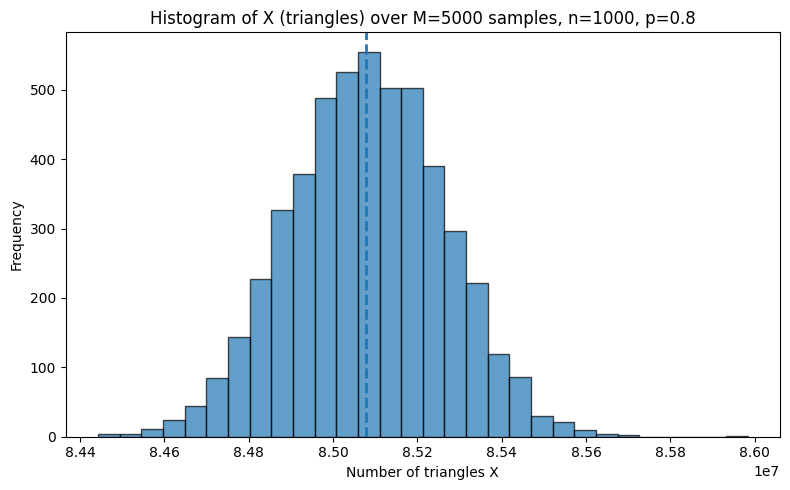

In [12]:
plt.figure(figsize=(8, 5))

plt.hist(X_values, bins=30, alpha=0.7, edgecolor="black")
plt.axvline(theo_mean, linestyle="--", linewidth=2)

plt.xlabel("Number of triangles X")
plt.ylabel("Frequency")
plt.title(f"Histogram of X (triangles) over M={M} samples, n={n}, p={p}")

plt.tight_layout()
plt.show()